## pytorch（神经网络分类任务） 

数据的读取

In [19]:
import warnings
from pathlib import Path
import requests
warnings.filterwarnings("ignore")
#下载数据集
DATA_PATH=Path("data")
PATH=DATA_PATH/'mnist'
PATH.mkdir(parents=True,exist_ok=True)
URL="http://deeplearning.net/data/mnist/"
FILENAME="mnist.pkl.gz"
if not (PATH/FILENAME).exists():
    content=requests.get(URL+FILENAME).content
    (PATH/FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip
with gzip.open((PATH/FILENAME).as_posix(),"rb") as f:
    ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding="latin-1")

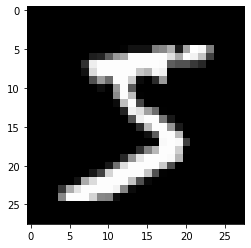

(50000, 784)


In [5]:
from matplotlib import pyplot
import numpy as np
pyplot.imshow(x_train[0].reshape((28,28)),cmap="gray")
pyplot.show()
print(x_train.shape)

In [7]:
import torch
#转换为tensor格式
x_train,y_train,x_valid,y_valid=map(
    torch.tensor,(x_train,y_train,x_valid,y_valid)
)

torch.nn.functional中有很多功能。那什么时候用nn.module,什么时候用nn.functional？一般情况下，如果模型有可学习的参数，最好用nn.module,其他情况nn.functional相对比较简单

In [21]:
import torch.nn.functional as F
import torch.nn as nn
#定义一些固定值
loss_func=F.cross_entropy
step=20
bs=64

定义模型

In [17]:
#定义网络模型
class Mnist_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(784,128)
        self.hidden2=nn.Linear(128,256)
        self.out=nn.Linear(256,10)
    def forward(self,x):
        x=F.relu(self.hidden1(x))
        x=F.relu(self.hidden2(x))
        x=self.out(x)
        return x
#进行梯度下降
def loss_batch(model,xx,yy,loss_func,opt=None):
    loss=loss_func(model(xx),yy)
    if opt!=None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(),len(xx)
#进行训练
def fit(step,model,loss_func,train_dl,test_dl,opt):
    for i in range(step):
        #训练
        model.train()
        for xx, yy in train_dl:
            loss,num=loss_batch(model,xx,yy,loss_func,opt)
        #验证：
        model.eval()
        with torch.no_grad():
            loss,num=zip(*[loss_batch(model,xx,yy,loss_func) for xx,yy in test_dl])
            print("验证集的损失值为:",np.sum(np.multiply(loss,num)/np.sum(num)))
    #预测结果的显示
    predict=np.argmax(model(torch.tensor(x_valid[0],dtype=torch.float)).data.numpy(),axis=0)
    pyplot.imshow(x_valid[0].reshape(28,28),cmap='gray')
    pyplot.show()
    print("当前的预测值为",predict)
#获得模型和优化器
def get_model():
    model=Mnist_nn()
    return model,torch.optim.SGD(model.parameters(),lr=0.01)

数据构造

验证集的损失值为: 0.8780187672615051
验证集的损失值为: 0.44123091945648196
验证集的损失值为: 0.3576239625930786
验证集的损失值为: 0.32258055434226995
验证集的损失值为: 0.30319221057891843
验证集的损失值为: 0.2832593293905258
验证集的损失值为: 0.26746041378974916
验证集的损失值为: 0.2555977565765381
验证集的损失值为: 0.24357888412475587
验证集的损失值为: 0.2336017012119293
验证集的损失值为: 0.223485861825943
验证集的损失值为: 0.2129057469844818
验证集的损失值为: 0.2043708380460739
验证集的损失值为: 0.2018336416721344
验证集的损失值为: 0.18848236579895017
验证集的损失值为: 0.1834354956150055
验证集的损失值为: 0.17755465812683108
验证集的损失值为: 0.1697735072016716
验证集的损失值为: 0.16725194489061831
验证集的损失值为: 0.16835437049269675


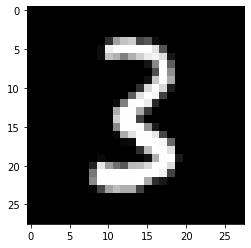

当前的预测值为 3


In [20]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
#使用tensordataset来转换数据格式，dataloader来划分训练集和测试集，以及实现mini-batch
train_ds=TensorDataset(x_train,y_train)
train_dl=DataLoader(train_ds,batch_size=bs,shuffle=True)
test_ds=TensorDataset(x_valid,y_valid)
test_dl=DataLoader(test_ds,batch_size=bs,shuffle=True)

model_mnist,optim=get_model()
fit(step,model_mnist,loss_func,train_dl,test_dl,optim)